<a href="https://colab.research.google.com/github/unique-subedi/stats604-project1/blob/main/604_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/github.com/unique-subedi/stats604-project1/blob/main/604_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open notebook on Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os



In [3]:
plates = {f"plate{fn[6:9]}": pd.read_csv(os.path.join("Data", fn), sep = '\t') for fn in os.listdir("Data")}

In [93]:
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

# arghh, got these +1s and -1s floating around cause the data's 1 indexed...
def gen_well_viz_property(plate, well_idx, property):
    well = plate[plate["WellIndex"] == well_idx + 1]
    well_rows, well_cols = 35, 20
    well_heatmap = np.zeros((well_rows, well_cols))
    well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1] = well[property]
    return well_heatmap

def viz_well(well_heatmap):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
    sns.heatmap(well_heatmap, ax=ax)
    plt.show()

def viz_plate_property(plate, property):    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
    plt.subplots_adjust(wspace=0, hspace=0)

    well_heatmaps = [gen_well_viz_property(plate, well_idx, property) for well_idx in range(8)]
    min_prop = np.min([well_heatmap.min() for well_heatmap in well_heatmaps])
    max_prop = np.max([well_heatmap.max() for well_heatmap in well_heatmaps])
    well_rows, well_cols = 35, 20

    for well_idx, well_heatmap in enumerate(well_heatmaps):
        well_row, well_col = well_idx // 4, well_idx % 4
        ax = axs[well_row, well_col]

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(left = False, bottom = False)

        ax.axhline(y=0, color='k',linewidth=3)
        ax.axhline(y=well_rows, color='k',linewidth=3)
        ax.axvline(x=0, color='k',linewidth=3)
        ax.axvline(x=well_cols, color='k',linewidth=3)

        sns.heatmap(well_heatmap, ax=ax, vmin=min_prop, vmax=max_prop, cbar=False, linewidths=1, linecolor='black')
    plt.show()

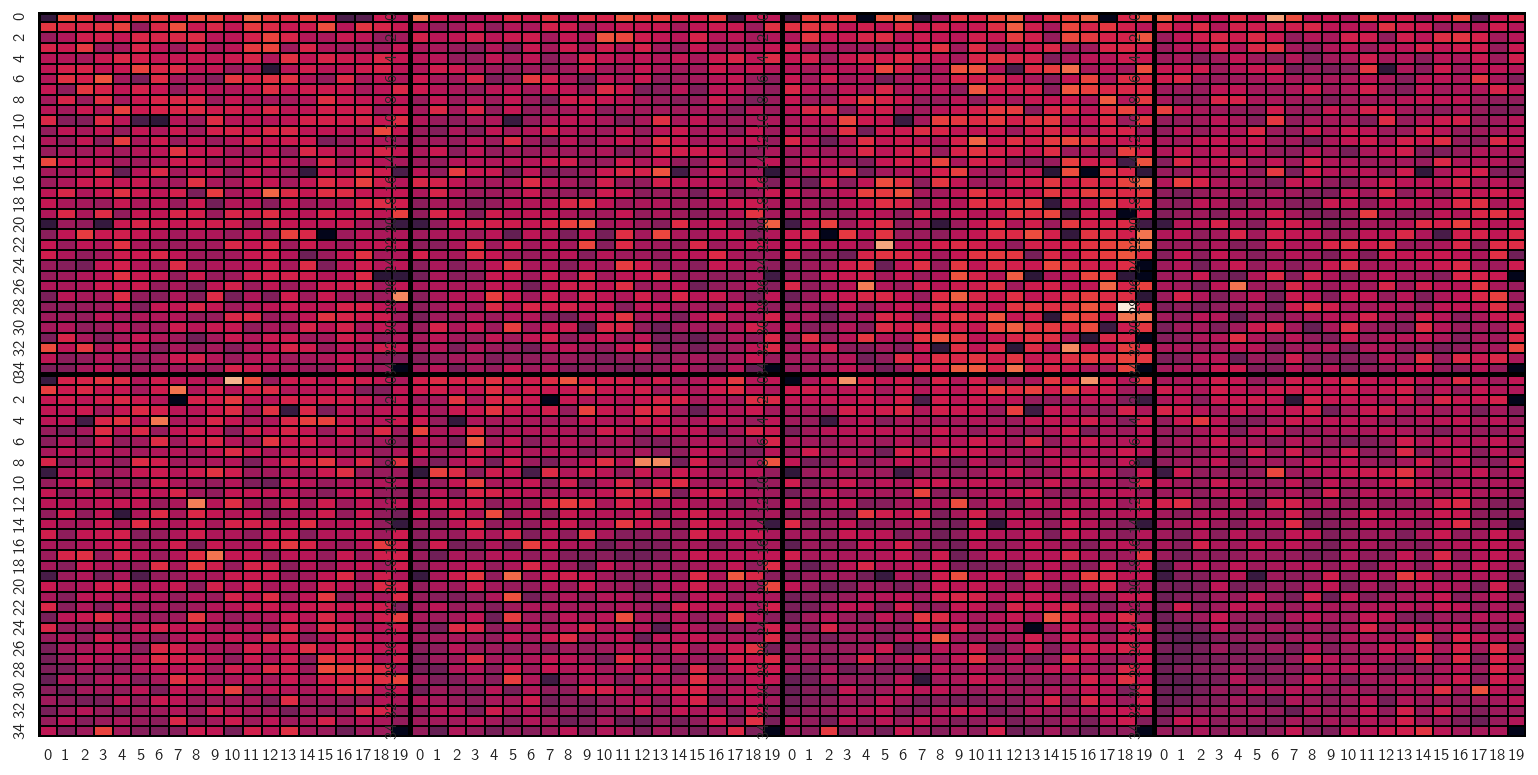

In [94]:
cur_plate = plates["plate516"]
viz_plate_property(cur_plate, "Nuclei_CP_AreaShape_Area")